# Gradient Descent - The numbers and the intuition

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
sns.set_theme()
np.random.seed(42)

Suppose you are a TV Producer and want to closely study how the budget of the TV show corresponds with views. You have a dataset containing both
- the budget of the TV show
- the number of views that show received per episode

Below is the plot of the data you collected

Text(0.5, 1.0, 'TV Show Views by Budget')

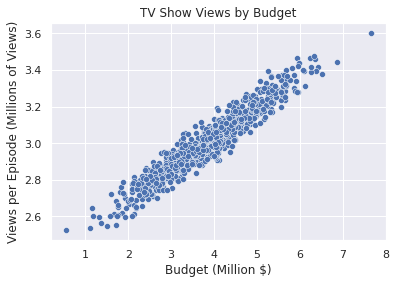

In [2]:
x, y = make_regression(1000, 1, noise=5, random_state=42)
x = np.ravel(x) + 3.8
y += 300
y /= 100
sns.scatterplot(x=x,y=y)
plt.xlabel("Budget (Million $)")
plt.ylabel("Views per Episode (Millions of Views)")
plt.title("TV Show Views by Budget")

You want to determine the budget needed to produce your new show, *Data Science Unleashed!*, and so you want to study the trend between the input budget and expected views. To do this, you to find a function $f$ that can predict the views per episode $y$ given the input budget $x$. This is the task of **Linear Regression**.

Problem: Data is slightly random and deviates from a perfect linear relationship, so no exact function exists to predict $y$ given $x$. We still want to be able to capture the general trend though. We will try 3 different but related strategies to try and figure out how to model this trend and predict the views per episode given the TV Show budget:
- Guess and Check
- Guess and Refine
- Numerical Guess and Refine = Gradient Descent

## Attempt \#1 - Guess and Check

The simplest approach is to guess random functions $f$ that best approximate the data. You notice that the trend is approximately linear, so you choose a linear function $$y = f(x;m,b) = mx + b$$ to model the trend. The notation of the values after ";" dictates $m$ and $b$ **parameters** of $f$ - these are the values which control how $f$ looks.

Then we will simply guess $m$ and $b$ and see which produces the best results.

Text(0, 0.5, 'Views per Episode (Millions of Views)')

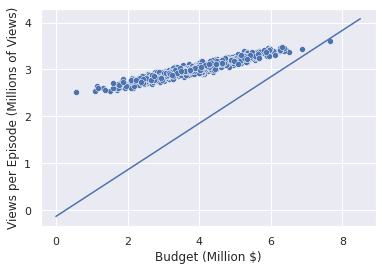

In [3]:
params = np.random.randn(2)
m, b = params[0], params[1]
def f(x):
    return m*x + b
input = np.arange(0, 9, 0.5)
y_pred = f(input)
sns.lineplot(x=input, y=y_pred)
sns.scatterplot(x=x,y=y)
plt.xlabel("Budget (Million $)")
plt.ylabel("Views per Episode (Millions of Views)")

We can produce a batch of guesses and see how good they are:

Text(0, 0.5, 'Views Per Episode (Millions)')

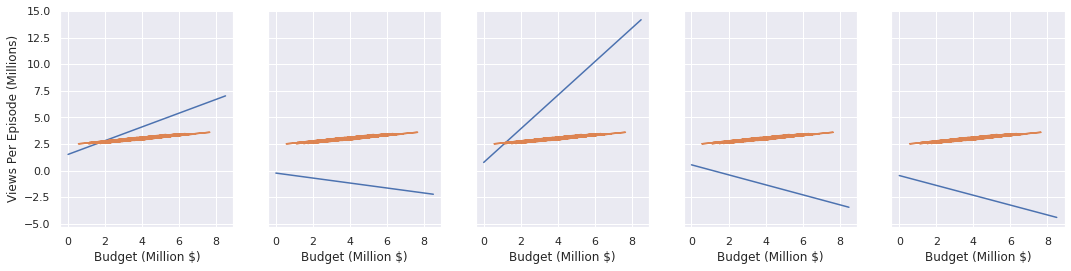

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=5, sharey=True, figsize=(18,4))
for i in range(5):
    params = np.random.randn(2)
    m, b = params[0], params[1]
    def f(x):
        return m*x + b
    input = np.arange(0, 9, 0.5)
    y_pred = f(input)
    ax[i].plot(input, y_pred)
    ax[i].plot(x, y)
    ax[i].set_xlabel("Budget (Million $)")
ax[0].set_ylabel("Views Per Episode (Millions)")

Judging by the quality of the results above, it may take a very long time to randomly reach a solution that adequately capture the underlying trend in the data. This method, while simple, is very inefficient in determining the value for the parameters $m$ and $b$ that best describe the underlying trend.

## Attempt 2 - Guess and *Refine*

We *don't* have to randomly guess though - we can visually look at how good $f$ is at explaining the trend in the data, and then tweak the values for $m$ and $b$ to improve $f$. Let's start off with some random value for $m$ and $b$ are refine from there!

In [5]:
params = np.random.randn(2)
m, b = params[0], params[1]
print(f"Initial Slope: {m}, Initial Intercept: {b}")

Initial Slope: 0.24196227156603412, Initial Intercept: -1.913280244657798


<AxesSubplot:>

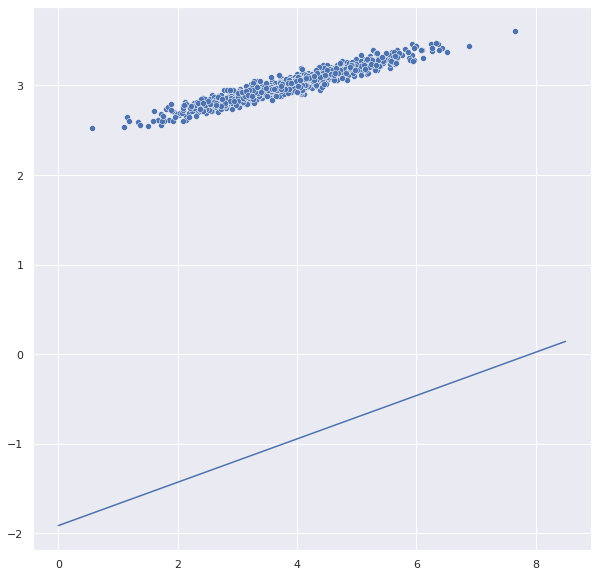

In [6]:
fig = plt.figure(figsize=(10,10))
def f(x):
    return m*x + b
input = np.arange(0, 9, 0.5)
y_pred = f(input)
sns.lineplot(x=input, y=y_pred)
sns.scatterplot(x=x,y=y)

What changes would you make to $m$ and $b$? Can you reach a near optimal solution in a couple of attempts? 

Unlike guessing randomly every time, we can iteratively improve on our initial guess to reach the best possible solution much faster. However, this is only feasible as we can easily visualize $f$. $f$ is a function from $\mathbb{R}$ to $\mathbb{R}$ (real numbers), which means we can easily visualize both inputs $x$ and outputs $y$ on a 2D plane. 

More generally though, ML problems have *tons* of dimensions. For example, consider the task of classifying this image as either a dog or a cat ("The Puppy, seen in Megalochori of Santorini" by Klearchos Kapoutsis is licensed under [CC-BY-ND 2.0](https://creativecommons.org/licenses/by/2.0/deed.en)).

![Picture of cute puppy](./The_Puppy.jpg)

This requires us to determine the function $f$ that maps this image to either 0 (a dog) or 1  (a cat). However, as this image is of size 1024 × 683 pixels with 3 color channels, this input image has 2098176 input values. That is to say, the input is in a 2098176 dimensional space! We are unable to visualize values that exist in that space. To learn $f$ in this case, we cannot visually inspect the fit manually change its parameters by hand. 

This motivates the need for a generalized algorithm that run on *any* machine learning task to optimize the values.

## Attempt 3 - Generalizing *Guess and Refine*

### Part 1 - Loss Functions

When we tried the guess and refine approach to figuring out $f$ to predict views per episode for a TV Show given its budget, we ended up using a strategy like this:
1. Try some value for $m$ and $b$
2. Look at the fit for the function $f$ defined by $m$ and $b$
3. Make changes to $m$ and $b$ to improve $f$ based on issues with current fit.

We would like to generalize these steps to work with models and values in which we are unable to visualize how well $f$ is able to capture the underlying trend (which is most models). There are couple things we need to be able to do:
- Determine a way to quantify "how good" $f$ is based on the current values of the parameters
- Determine a way to update the parameters based on the previous notion of "goodness of fit"

Tackling the first problem, we can return to our visualization of the TV Show data

Text(0, 0.5, 'Views per Episode (Millions of Views)')

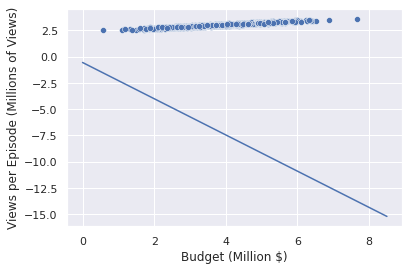

In [7]:
params = np.random.randn(2)
m, b = params[0], params[1]
def f(x):
    return m*x + b
input = np.arange(0, 9, 0.5)
y_pred = f(input)
sns.lineplot(x=input, y=y_pred)
sns.scatterplot(x=x,y=y)
plt.xlabel("Budget (Million $)")
plt.ylabel("Views per Episode (Millions of Views)")

$f$ tells us for each input budget $x$ what the expected view should be. However, we can see visually this is a horrible fit. For example, the TV Show with budget $4 million should receive about 3 million views per episode. However, when we enter this input budget into $f$, we get a very different answer:

In [8]:
f(4)

-7.461958859293103

Our current model predicts the TV Show should receive -7.46 million views per episode, which is *extremely* wrong (what is a negative view?). However, this method of comparing the actual value to the predicted value gives us a good way to quantify how "good' $f$ is currently.

Considering more generally a datapoint in our dataset $(x,y)$ where
- $x$ is the budget of the TV Show
- $y$ is the actual views per episode of that TV show

we can evaluate the fit of $f$ by comparing $f(x;m,b)$, the predicted views per episode, to $y$, the actual views per episode. If
- $f(x;m,b)$ is very different from $y$, $f$ is doing very badly - it should make predictions close to $y$
- $f(x;m,b)$ is close to $y$ (for example, within $\pm 50000$ views), $f$ is doing quite good

Therefore $f(x;m,b) - y$ gives us a numerical measure of how good $f$ is at predicting the views per episode $y$. This value technically can be positive or negative, so lets square it to always make this difference positive - $(f(x;m,b) - y)^2$. We will see later that this square leads to having a very nice property.

Then if
- $(f(x;m,b) - y)^2$ is large, $f(x;m,b)$ is very different than $y$ for this example, and so $f$ is doing a bad job
- $(f(x;m,b) - y)^2$ is small, $f(x;m,b)$ is close to $y$ and is doing a pretty good job predicting views per episode given the budget.

If we average this value over all the tv shows and data we have in our dataset, we can obtain an average measure of how good our model is doing. If we say $(x_i, y_i)$ represents the $i$ th TV Show budget and views per episode pair in our dataset (with $n$ such datapoints in our dataset), we can define what we call a **loss function** denoted $L(m,b)$
$$L(m,b) = \frac{1}{n}\sum_{i=1}^n (f(x;m,b)-y)^2$$ 
This function can be defined in python as below

In [9]:
def f(x, m , b):
    """
    An arbitrary linear function

    Args:
        x (float): Input value to return output for
        m (float): Parameter describing the slope of the linear function
        b (float): Parameter describing the intercept of the linear function

    Returns:
        float: output value
    """
    return m*x + b

def loss(m,b, x, y):
    """
    Computes the loss of function f on dataset (x,y).

    Args:
        m (float): Slope parameter for f
        b (float): Intercept parameter for f
        x (float): Input value to f 
        y (float): Expected output from f

    Returns:
        float: Loss of f on the dataset
    """
    pred = f(x, m, b)
    l = 0
    n = len(x)
    for predicted, actual in zip(pred, y):
        l += (predicted-actual)**2
    return l / n 

If we run the loss function above, we can compute a measure of how bad $f$ is

In [10]:
loss(m, b, x, y)

106.5299375900934

Our loss is 106.53! That's pretty bad, which aligns with our visual intuition - $f$ does not look like it predicts the output views per episode very well as the data is not aligned with $f$

Text(0, 0.5, 'Views per Episode (Millions of Views)')

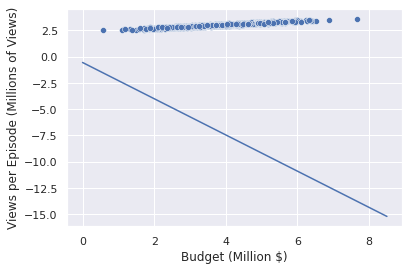

In [11]:
sns.lineplot(x=input, y=y_pred)
sns.scatterplot(x=x,y=y)
plt.xlabel("Budget (Million $)")
plt.ylabel("Views per Episode (Millions of Views)")

Suppose we set $m$ to be 0.3 and $b$ to be 2. Then we can observe $f$ now looks like

Text(0, 0.5, 'Views per Episode (Millions of Views)')

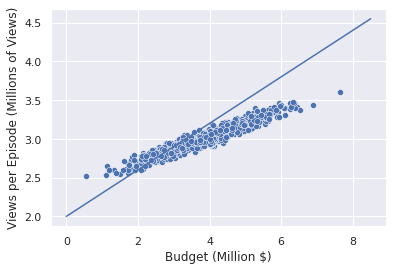

In [12]:
m = 0.3
b = 2
pred = f(input, m, b)
sns.lineplot(x=input, y=pred)
sns.scatterplot(x=x,y=y)
plt.xlabel("Budget (Million $)")
plt.ylabel("Views per Episode (Millions of Views)")

While not perfect, this is a much better fit. We can confirm this by noticing how our loss value is much lower now!

In [13]:
loss(m,b,x,y)

0.03968058070010659

0.0397 is *much* better than 106.53. This hopefully shows you how our loss function $L$ perfectly captures how "good" our function $f$ is at predicting the output variable $y$. While we define $L$ here in a very specific manner for our current problem, many ML tasks require practioners to define loss functions that quantify how good $f$ is at predicting the target value. Choosing the right loss function for the problem is one of the most crucial parts of working on any ML task.

### Part 2 - Gradient Descent

While now we have a numerical way to quantify how good $f$ is, we still have to address the second part - changing $m$ and $b$ automatically based on the loss computed to decrease the loss and improve $f$. To see how we might do this, lets fix $b = 2$ on our current dataset and vary the slope from -0.5 to 1, at each step plotting what the loss of $f$ is

Text(0, 0.5, 'Loss of $L$')

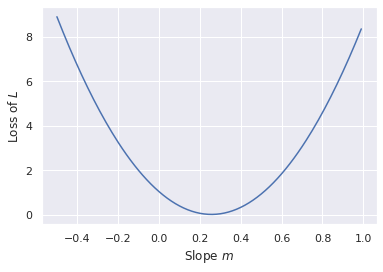

In [14]:
b = 2
losses = []
slope_values = np.arange(-0.5,1, 0.01)
for i in slope_values:
    losses.append(loss(i, b, x, y))
sns.lineplot(x=slope_values, y=losses)
plt.xlabel("Slope $m$")
plt.ylabel("Loss of $L$")

We see that for different values of the slope, the loss values follow this wonderful parabolic shape (this is the reason why we squared the difference $f(x:m,b) - y$ instead of taking an absolute value). More specifically, we can say that when $m \approx 0.25$ the loss is about 0, which is what we prefer. Recall that when the loss is small, $f$ is better at predicting the views per episode given the input budget.

This point $m \approx 0.25$ corresponds to a **minimum** of the loss function as seen visually. Therefore, to find the best slope $m$ to make $f$ the best it can be at predicting the output views per episode, it is necessary to set the minimizing parameters $m^* \approx 0.25$ of $L$. However generally we won't be able to visualize the loss function, and so it is required to find the minima of $L$ some other way. 

In calculus classes, you would've done such a task using this approach:
1. Find the critical points of $L$
2. Check the critical points to see if they are minima, maxima, or saddle points.
3. Considering the minima only, find the smallest possible minima
4. Record the value of $m^*$ being the slope which minimizes $L$

However, this method doesn't scale well with the dimension of the datapoints. In multiple dimensions, this involves computing something called a Hessian matrix, which can be *enormous* if the input data is high dimensional (as is the case in ML). Instead, we'll try a different approach.

Suppose our initial guess is $m = 1$. Our loss at this value would be:

In [15]:
loss(1, 2, x, y)

8.596450215146078

This isn't great, but let's see if we can improve. We want to change $m$ in the direction that decreases $L$. This leaves us with two options:
- move left (subtract something from $m$)
- move right (add something to $m$)

Lets actually move left and right by $\Delta m = 0.1$ and see how the loss changes

In [16]:
print(f"Moving left - loss changes to {loss(0.9, 2, x, y)} from {loss(1, 2, x, y)}")
print(f"Moving right - loss changes to {loss(1.1, 2, x, y)} from {loss(1, 2, x, y)}")

Moving left - loss changes to 6.44134241254055 from 8.596450215146078
Moving right - loss changes to 11.062462064598867 from 8.596450215146078


We can see then that by moving *left* we can decrease the value of the loss function. Recall a decreasing value of the loss function corresponds to $f$ getting better at predicting the views per episode given the input budget. Therefore, we want to change $m$ to $m = 1-0.1 = 0.9$.

We can try this step again - move left or right by 0.1 and see which descreases the loss more

In [18]:
print(f"Moving left - loss changes to {loss(0.8, 2, x, y)} from {loss(0.9, 2, x, y)}")
print(f"Moving right - loss changes to {loss(1, 2, x, y)} from {loss(0.9, 2, x, y)}")

Moving left - loss changes to 4.597138656782311 from 6.44134241254055
Moving right - loss changes to 8.596450215146078 from 6.44134241254055


Again, by moving *left* the loss decreases, so we should decrease $m$ by 0.1 to $m = 0.8$.

If we repeat this step many times, eventually we will find that moving either left or right will increase the loss, indicating that we are at a minimum point. This is another way for us to minimize the loss function! This defines a new procedure for finding the optimal values of $m$ and $b$:
1. Try current values of $m$ and $b$
2. Evaluate loss of $f(x;m,b)$ given those $m$ and $b$
3. Check which direction we must change $m$ and $b$ to minimize $L$
4. Change $m$ and $b$. Repeat step 1 until the loss does not change by moving in any direction

Notice how this is very similar to the procedure we tried when guessing and refining. This algorithm generalizes this approach to only depend on the loss function $L$, making it more useful in higher dimensional problems where we *can't* visualize the function $f$ and the dataset!

This algorithm is called **gradient descent**, which is a weird name at first glance. Lets unpack it though, because there is actually an amazing insight that we've glossed over. 

**Descent** refers to the idea that we are moving downwards along the loss parabola

Text(0, 0.5, 'Loss of $L$')

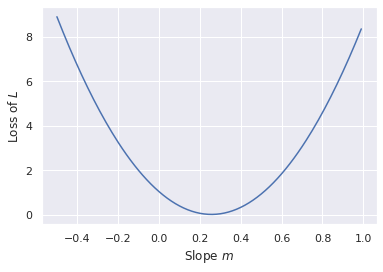

In [91]:
b = 2
losses = []
slope_values = np.arange(-0.5,1, 0.01)
for i in slope_values:
    losses.append(loss(i, b, x, y))
sns.lineplot(x=slope_values, y=losses)
plt.xlabel("Slope $m$")
plt.ylabel("Loss of $L$")

We were moving from $m = 1$ to $m \approx 0.25$, which corresponds to a *decrease* of loss from about $8$ to some smaller number close to $0$.

What does the **gradient** refer to? Lets take a look at the decision making process we were using before to move in a direction which minimizes loss:

In [93]:
print(f"Moving left - loss changes to {loss(0.9, 2, x, y)} from {loss(1, 2, x, y)}")
print(f"Moving right - loss changes to {loss(1.1, 2, x, y)} from {loss(1, 2, x, y)}")

Moving left - loss changes to 6.44134241254055 from 8.596450215146078
Moving right - loss changes to 11.062462064598867 from 8.596450215146078


We decided to move left because we found that 
- $L$ decreased from $8.60$ to $6.44$ when $\Delta m = -0.1$
- $L$ increased from $8.60$ to $11.062$ when $\Delta m = 0.1$

Therefore, when moving left, the loss decreased, and so we will move that direction.

Restating this decision process in terms of the *slope (derivative)* of the loss curve $L$ - the slope of the loss curve can be approximated as $$(\frac{L(m+\Delta m) - L(m)}{\Delta m} + \frac{L(m)-L(m-\Delta m)}{\Delta m})/2$$ 
which we compute to be 23.11. This means that if we increase $m$ by approximately $\Delta m$, $L$ will *increase* by $\Delta m * 23.11$. We want to decrease loss, so instead  we will decrease $m$ by $\Delta m$. 

That is to say - we can look at the sign of the *slope (derivative)* of the loss curve $L$ to determine which direction to move:
- If $\frac{\Delta L}{\Delta m}$ is positive, we will lower loss by moving left (decreasing $m$)
- If $\frac{\Delta L}{\Delta m}$ is negative, we will lower loss by moving right (increasing $m$)

Of course, generally, $L$ doesn't have a slope, but a *derivative* $\frac{\partial L}{\partial m}$ that describes how the output loss $L$ changes with respect to the input parameter $m$. In multivariate calculus, the more general form of a deriviative is called a **gradient**, denoted by $\nabla L$ which is a derivative with respect to *all* input parameters. In this case, as our only parameters are the slope of $f$, $m$, and the intercept of $f$, $b$, we can write $\nabla L$ as  $$\nabla L = [\frac{\partial L}{\partial m}, \frac{\partial L}{\partial b}]$$
This is where the **gradient** in gradient descent comes from! To determine what change to make to $m$ to decrease loss, we can look at the *gradient* (*derivative*) of the loss function with respect to $m$!
- if $\frac{\partial L}{\partial m}$ is positive, then increasing $m$ will increase the loss $L$ and worsen $f$'s ability to predict the output correctly. Therefore we will decrease $m$
- if $\frac{\partial L}{\partial m}$ is negative, then increasing $m$ will decrease the loss $L$ and improve $f$'s ability to predict the output correctly. Therefore we will increase $m$

# Gradient Descent, Generalized

While our example with the TV Shows allows us to visualize and intuit a way to figure out $m$ and $b$ so that $f(x;m,b)$ can predict the views per episode given the budget allocated to that show, we would like to generalize Gradient Descent so it can work on *any* machine learning model.

## Dataset and Model Definition

We define our dataset as a collection of data points $\{(x_i, y_i)\}_{i=1}^n$ where
- $x_i$ is the input variables we already have
- $y_i$ is the output variables we would like to predict given $x_i$

Then our machine learning model is simply a function $f(x;\theta)$ which when given input variables $x$, and parameter set $\theta$ that defines the beheavior of $f$, we would like to predict $y = f(x,\theta)$ that corresponds to the input variables. 

This is no different from the TV Show example:
- the input variables $x_i$ are just the proposed TV Show budget
- the output variables $y_i$ are the views per episode given the TV Show budget
- the machine learning model $f$ is just the linear function $mx +b$ that we are using to model the relationship between views per episode and TV Show budget
- the parameters $\theta$ are just the slope $m$ of $f$ and the intercept $b$ of $f$. That is, $\theta = \{m,b\}$

## Loss Function Definition

We define our loss function as $L(\theta)$ that takes in the current values of the parameters and outputs the loss over the entire dataset. Don't get caught up in notation - $L(\theta)$ just describes how good $f$ is at predicting the output variables $y$ when the parameters governing its behavior are $\theta$. 

In the previous example, $$L(\theta) = L(m,b) = \frac{1}{n}\sum_{i=1}^n (f(x;m,b)-y)^2$$ which we call **mean squared error** or **least squares loss**. This loss function is actually commonly used to perform many types of regression tasks.

## Gradient Descent Algorithm

Given those definitions, we can generally define the gradient descent algorithm:

- Guess some initial value for the parameters $\theta$
- While loss is not at a minimum
    1. Compute the loss of the dataset given the current parameter value $\theta$: $$\ell = L(\theta)$$
    2. Compute the derivatives of the loss function at the current parameter values: $\nabla \ell$
    3. Update each parameter by moving in the direction of the greatest loss decrease: $$\theta  = \theta - \alpha \nabla \ell$$

While this looks complicated, we can rewrite this algorithm in the context of our linear model example to see that it really is no different from the process we were doing implicitly: 

- Guess some initial value for the parameters $\theta = [m,b]$
- While loss is not at a minimum
    1. Compute the loss of the dataset given the current parameter value $\theta$: $$\ell = L(m,b)$$
    2. Compute the derivatives of the loss function at the current parameter values: $\nabla \ell = \nabla L(m,b) = [\frac{\partial L}{\partial m}, \frac{\partial L}{\partial b}]$
    3. Update each parameter by moving in the direction of the greatest loss decrease: $$\theta  = \theta - \alpha \nabla \ell$$ or equivalently $$[m,b]  = [m,b] - \alpha[\frac{\partial L}{\partial m}, \frac{\partial L}{\partial b}]$$ This really decomposes into two parameter updates:
        - $m = m-\alpha*\frac{\partial L}{\partial m}$
        - $b = b-\alpha*\frac{\partial L}{\partial b}$
        
This is the same intuition as before:
- If $\frac{\partial L}{\partial m} > 0$, then increasing $m$ increases $L$. Therefore, we decrease $m$ by a factor of $\alpha*|\frac{\partial L}{\partial m}|$. This is equivalent to subtracting $\alpha*|\frac{\partial L}{\partial m}|$ from $m$, or $m - \alpha*|\frac{\partial L}{\partial m}|$.
- If $\frac{\partial L}{\partial m} < 0$, then increasing $m$ decrease $L$. Therefore, we increase $m$ by a factor of $\alpha*|\frac{\partial L}{\partial m}|$. This is equivalent to adding $\alpha*|\frac{\partial L}{\partial m}|$ to $m$, or $m + \alpha*|\frac{\partial L}{\partial m}|$

These addition and subtraction mechanics can be simplified by using the signed value as below: $$m = m-\alpha*\frac{\partial L}{\partial m}$$ This is an equivalent and faster way to compute the same output.

We move by a factor of $\alpha*\frac{\partial L}{\partial m}$, which has two important details:
- $\alpha$ is used to dictate how far we move in the direction of decreasing loss. If $\alpha$ is large, then we change $m$ by alot, and if $\alpha$ is small, we change $m$ minimally. As machine learning specialists, it is up to us to decide what $\alpha$ to choose, but a good default is $\alpha = 1*10^{-3}$, from which further changes can be made based on what helps the model learn best
- We use the derivative itself $\frac{\partial L}{\partial m}$ as part of how far to move so we don't overshoot the minimum. Suppose we moved by a constant amount every time - we might accidentally overshoot the minimum value by moving too far in the direction of choice. Recalling that $|\frac{\partial L}{\partial m}|$ gets smaller as we get closer to the minimum value for $L$, this means we take smaller and smaller steps as we get closer to the minimum value, making it so we are more likely to reach the minimum value.

# Next Steps
Gradient Descent is an amazing algorithm that drives most machine learning and AI advancements that exist today. That said, there are some significant problems with gradient descent
- We have to compute the loss and the gradients of $L$ over the *entire* dataset, which can have millions of rows each with millions of values. This can make computing the loss and gradients very inefficient.
- We choose to change parameters in the direction which decreases loss, but we don't know if we are heading towards a *global* minimum or a *local* minimum. As a result, gradient descent can cause an ML model to converge to having worse performance than it could.

There are many small variations on Gradient Descent which aim to solve these issues, some which we'll implement (for example, Stochastic Gradient Descent), and some which are more complex but more prevalent in practice (for example, Momentum, RMSProp, and Adam) 